<b> Importing the Libraries

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data.dataloader import DataLoader
from torchvision import transforms
import torch
import pandas as pd
import numpy as np
from torch import nn, optim
import warnings
warnings.filterwarnings("ignore")
from torch.nn import Module, Conv2d, Linear, MaxPool2d, AdaptiveAvgPool1d
from torch.nn.functional import relu, dropout

<b> Google Drive Authentication

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<b> Getting the PetImages Dataset from the drive

In [ ]:
path = "/content/drive/MyDrive/kagglecatsanddogs_3367a/PetImages"

In [ ]:
dataset = ImageFolder(path)


 Total images in the dataset are 25006

In [ ]:
print("Length of dataset",len(dataset))

Length of dataset 25006


Due to computational retarints as the GPU in google colab is exceeding its limit, on running several batches and for different optimizers functions, have reduced the size of dataset to 6252

In [ ]:
dataset_new = dataset
len(dataset_new)

25006

In [ ]:
for i in range(int(len(dataset)/2)):
  dataset_new.imgs.remove((dataset_new.imgs[i][0], dataset_new.imgs[i][1]))
  dataset_new.targets.pop(i)

d1 = dataset_new
for i in range(int(len(dataset_new)/2)):
  d1.imgs.remove((d1.imgs[i][0], d1.imgs[i][1]))
  d1.targets.pop(i)

In [ ]:
print("Length of reduced dataset",len(d1))
data = d1

Length of reduced dataset 6252


<b> The PetImages consists of two classes Cat and Dog

In [ ]:
classes = data.classes
classes

['Cat', 'Dog']

In [ ]:
X= data.imgs
y=data.targets

In [ ]:
print("X length : ",len(X))
print("y length : ",len(y))

X length :  6252
y length :  6252


Total length of Dataset is 6252 with 3125 images belongings to class "Cats" and 3127 images belonging to class "Dogs"

In [ ]:
from collections import Counter
print(Counter(y).keys())
#0 : Cat    1: Dog
print(Counter(y).values()) 
pet_class_count = Counter(y).values()


dict_keys([0, 1])
dict_values([3125, 3127])


<b> Visualizing the images

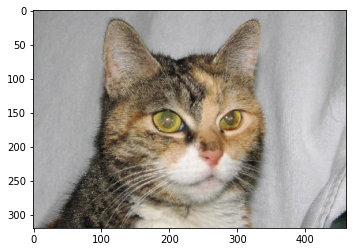

In [ ]:
image =Image.open(X[2][0])
plt.imshow(image)

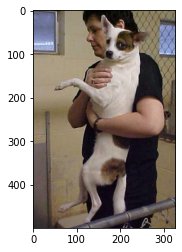

In [ ]:
image =Image.open(X[4000][0])
plt.imshow(image)

Transforming the image. Operations involved: Resize, Converting to Tensor and Normalization

In [ ]:
transform = transforms.Compose([
	transforms.Resize((400,400)),
	transforms.ToTensor(),
  transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

<b>Train Test Split (70:30)

In [ ]:
nX=[]
ny=[]
for each in X:
  nX.append(each)
  ny.append(each[1])
X=nX
y=ny
trainData,testData,trainLabel,testLabel = train_test_split(X,y,test_size=0.3,random_state=0)

In [ ]:
print("Data size",len(X))
print("Train Dataset Size: ", len(trainData))
print("Test Dataset Size: ", len(testData))
type(trainData)


Data size 6252
Train Dataset Size:  4376
Test Dataset Size:  1876


list

Moving data and labels to GPU if available

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


<b> Defining class Image loader, for image data preprocessing</b>. 
<p>Operations Involved</p>
<p>1. Removing Grayscale Images</p>
<p>2. Resizing all the images to the same dimension.</p>
<p>3. Image Transformation</p>

In [ ]:
#Taken help from a youtube channel for Transformation Class
class PetImageLoader(Dataset):
  def __init__(self,dataset, transform = None):
    self.dataset = self.checkImageChannel(dataset)
    self.transform = transform

  def checkImageChannel(self,dataset):
    dRGB=[]
    for index in range(len(dataset)):
      if Image.open(dataset[index][0]).getbands() == ('R','G','B'):
        dRGB.append(dataset[index])
    return dRGB
  
  def getResizedImage(self,item):
    image = Image.open(self.dataset[item][0])
    _,_,width,height = image.getbbox()
    if width>height:
      factor=(0,0,width,width)
    else:
      factor = (0,0,height,height)
    return image.crop(factor) 
    
  def __getitem__(self,item):
    image = self.getResizedImage(item)
    if transform is not None:
      return self.transform(image), self.dataset[item][1]
    return image, self.dataset[item][1]

  def __len__(self):
    return len(self.dataset)

Converting Train & Test data into tensor class

In [ ]:
trainImageLoader = PetImageLoader(trainData,transform)

In [ ]:
testImageLoader = PetImageLoader(testData,transform)

In [ ]:
print("Train Dataset Size: ", len(trainData))
print("Length of trainImageLoader",len(trainImageLoader))
print("Removed grayscale image count in train data: ",len(trainData)-len(trainImageLoader) )


Train Dataset Size:  4376
Length of trainImageLoader 4362
Removed grayscale image count in train data:  14


In [ ]:
print("Test Dataset Size: ", len(testData))
print("Length of testImageLoader",len(testImageLoader))
print("Removed grayscale image count in test data: ",len(testData)-len(testImageLoader) )

Test Dataset Size:  1876
Length of testImageLoader 1873
Removed grayscale image count in test data:  3


<b> Three Layered CNN Network

In [ ]:
#CNN Network
class CNNNetwork(nn.Module):
    def __init__(self,num_classes=6):
        super(CNNNetwork,self).__init__()
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=64,kernel_size=5,stride=1,padding=1)
        self.bn1=nn.BatchNorm2d(num_features=64)
        self.relu1=nn.ReLU()        
        self.pool=nn.MaxPool2d(kernel_size=5)
    
        self.conv2=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1)
        self.relu2=nn.ReLU()       
        
        self.conv3=nn.Conv2d(in_channels=128,out_channels=256,kernel_size=5,stride=1,padding=1)
        self.bn3=nn.BatchNorm2d(num_features=256)
        self.relu3=nn.ReLU()

        self.adPooling = AdaptiveAvgPool1d(256)
        self.fc1 = Linear(in_features =256, out_features =128)
        self.fc2 = Linear(in_features = 128, out_features =64)
        self.out = Linear(in_features =64, out_features =2)
        self.out = Linear(in_features =128, out_features =2)

    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)

        output = dropout(output)
        output = output.view(1, output.size()[0], -1)
        output = self.adPooling(output).squeeze()
      
        output = self.fc1(output)
        output = relu(output)

        output = self.fc2(output)
        output = relu(output)
            
        return output

In [ ]:
model = CNNNetwork().to(device)
loss_function = nn.CrossEntropyLoss()

In [ ]:
from torchsummary import summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 222, 222]           4,864
       BatchNorm2d-2         [-1, 64, 222, 222]             128
              ReLU-3         [-1, 64, 222, 222]               0
         MaxPool2d-4           [-1, 64, 44, 44]               0
            Conv2d-5          [-1, 128, 44, 44]          73,856
              ReLU-6          [-1, 128, 44, 44]               0
            Conv2d-7          [-1, 256, 42, 42]         819,456
       BatchNorm2d-8          [-1, 256, 42, 42]             512
              ReLU-9          [-1, 256, 42, 42]               0
AdaptiveAvgPool1d-10               [-1, 2, 256]               0
           Linear-11                  [-1, 128]          32,896
           Linear-12                   [-1, 64]           8,256
Total params: 939,968
Trainable params: 939,968
Non-trainable params: 0
-------------------------------

<b> Visualizing one batch of train dataloader

In [ ]:
batch_size = 64
trainDataLoader = DataLoader(trainImageLoader, batch_size =batch_size, shuffle = True,pin_memory =True)
testDataLoader = DataLoader(testImageLoader, batch_size =batch_size, shuffle = True,pin_memory =True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Images Shape: torch.Size([64, 3, 400, 400])


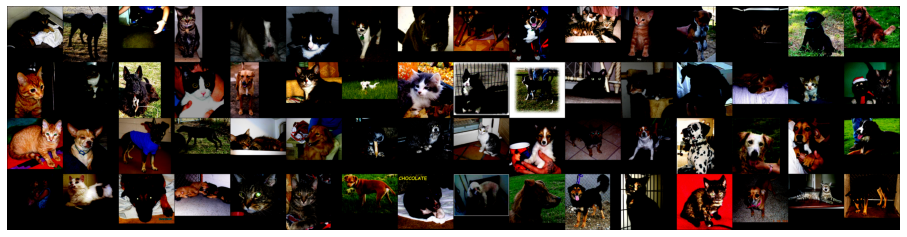

In [ ]:
from torchvision.utils import make_grid
for images, labels in trainDataLoader:
    print('Images Shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

<b> Vanilla SGD

In [ ]:
batch_size = 1
trainDataLoader = DataLoader(trainImageLoader, batch_size =len(trainImageLoader), shuffle = True,pin_memory =True)
testDataLoader = DataLoader(testImageLoader, batch_size =len(trainImageLoader), shuffle = True,pin_memory =True)

In [ ]:
print("Train Dataset Size: ", len(trainImageLoader))
print("Length of Train Data Loader",len(trainDataLoader))

Train Dataset Size:  4362
Length of Train Data Loader 4362


In [ ]:
print("Train Dataset Size: ", len(testImageLoader))
print("Length of Train Data Loader",len(testDataLoader))

Train Dataset Size:  1873
Length of Train Data Loader 1873


In [ ]:
optimizer = torch.optim.SGD(model.parameters(),lr=0.1)
torch.cuda.empty_cache()

In [ ]:
model.train()
train_len = len(trainData)
loss_ =[]

num_epochs = 5
for epoch in range(num_epochs):
  total_correct =0.0
  r_loss=0.0

  for i, (images, labels) in enumerate(trainDataLoader):

        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        output_label = torch.argmax(outputs,dim=1)
        total_correct+= (labels==output_label).sum().item()

        optimizer.zero_grad()
        loss = loss_function(outputs, labels)
        r_loss += loss.item()*images.size(0)

        # Backward and optimize
        loss.backward()
        optimizer.step()
  loss_.append(r_loss/train_len)
  print(f'Epoch: {epoch} Loss :{r_loss/train_len}  Accuracy :{total_correct/train_len*100}%')
print("Finished Training")

In [ ]:
df= pd.DataFrame()
df['loss']=loss_
df['epoch']=[i for i in range(1,num_epochs+1)]
plt.plot(df.epoch,df.loss)
plt.title("Cross entropy Loss in each epoch")
plt.xlabel("epoch")
plt.ylabel("Loss")

In [ ]:
correct_predction = {label: 0 for label in classes}
total_predction = {label: 0 for label in classes}
with torch.no_grad():
  model.eval()
  n_correct=0.0

  for i, (images, labels) in enumerate(testDataLoader):
        images = images.to(device)
        labels = labels.to(device)
        #print(i)
        if (i!=117):
      # Forward pass
          outputs = model(images)
          output_labels = torch.argmax(outputs,dim=1)

          n_correct += sum(labels==output_labels)

          #Checking Classwise Correct Prediction
          for j in range(batch_size):
            if labels[j] == output_labels[j]:
                  correct_predction[classes[labels[j]]]+= 1
                
            total_predction[classes[labels[j]]] += 1

print(f'Accuracy on test data: {100 * n_correct // len(testData)} %')

for label, correct_count in correct_predction.items():
    print("Accuracy for Class : ",label," is ",str(round(100 * (float(correct_count) / total_predction[label]),2)),"%",sep=" ")

<b> Mini Batch with SGD

<b> Batch Size =16

In [ ]:
batch_size = 16
trainDataLoader = DataLoader(trainImageLoader, batch_size =batch_size, shuffle = True,pin_memory =True)
testDataLoader = DataLoader(testImageLoader, batch_size =batch_size, shuffle = True,pin_memory =True)

In [ ]:
print("Train Dataset Size: ", len(trainImageLoader))
print("Length of Train Data Loader",len(trainDataLoader))

Train Dataset Size:  4362
Length of Train Data Loader 273


In [ ]:
print("Train Dataset Size: ", len(testImageLoader))
print("Length of Train Data Loader",len(testDataLoader))

Train Dataset Size:  1873
Length of Train Data Loader 118


In [ ]:
optimizer = torch.optim.SGD(model.parameters(),lr=0.0001)

In [ ]:
torch.cuda.empty_cache()

<b> Training the model

In [ ]:
model.train()
train_len = len(trainData)
loss_ =[]
accuracy_ =[]

num_epochs = 5
for epoch in range(num_epochs):
  total_correct =0.0
  r_loss=0.0

  for i, (images, labels) in enumerate(trainDataLoader):

        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        output_label = torch.argmax(outputs,dim=1)
        total_correct+= (labels==output_label).sum().item()

        optimizer.zero_grad()
        loss = loss_function(outputs, labels)
        r_loss += loss.item()*images.size(0)
        

        # Backward and optimize
        loss.backward()
        optimizer.step()
  loss_.append(r_loss/train_len)
  accuracy_.append(total_correct/train_len)
  print(f'Epoch: {epoch} Loss :{r_loss/train_len}  Accuracy :{total_correct/train_len*100}%')
print("Finished Training")

Epoch: 0 Loss :4.038207085956385  Accuracy :36.0146252285192%
Epoch: 1 Loss :3.893679199750506  Accuracy :52.78793418647167%
Epoch: 2 Loss :3.7430718009389077  Accuracy :55.16453382084096%
Epoch: 3 Loss :3.582787113499162  Accuracy :56.764168190127975%
Epoch: 4 Loss :3.4028411572986372  Accuracy :56.96983546617916%
Finished Training


Text(0, 0.5, 'Accuracy')

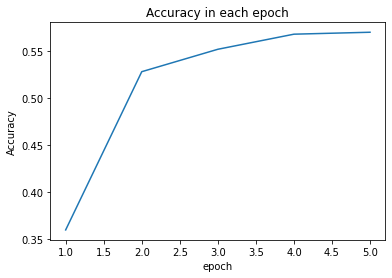

In [ ]:
df= pd.DataFrame()
df['accuracy']=accuracy_
df['epoch']=[i for i in range(1,num_epochs+1)]
plt.plot(df.epoch,df.accuracy)
plt.title("Accuracy in each epoch")
plt.xlabel("epoch")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Loss')

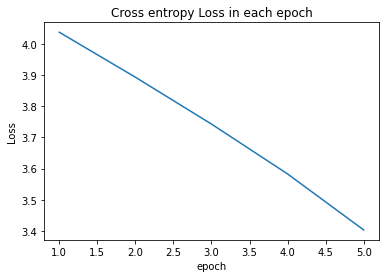

In [ ]:
df= pd.DataFrame()
df['loss']=loss_
df['epoch']=[i for i in range(1,num_epochs+1)]
plt.plot(df.epoch,df.loss)
plt.title("Cross entropy Loss in each epoch")
plt.xlabel("epoch")
plt.ylabel("Loss")

In [ ]:
correct_predction = {label: 0 for label in classes}
total_predction = {label: 0 for label in classes}
batch_size =4
with torch.no_grad():
  model.eval()
  n_correct=0.0

  for i, (images, labels) in enumerate(testDataLoader):
        images = images.to(device)
        labels = labels.to(device)
        if (i!=117):
      # Forward pass
          outputs = model(images)
          output_labels = torch.argmax(outputs,dim=1)

          n_correct += sum(labels==output_labels)

          #Checking Classwise Correct Prediction
          for j in range(batch_size):
            if labels[j] == output_labels[j]:
                  correct_predction[classes[labels[j]]]+= 1
                
            total_predction[classes[labels[j]]] += 1

print(f'Accuracy on test data: {100 * n_correct // len(testData)} %')

for label, correct_count in correct_predction.items():
    print("Accuracy for Class : ",label," is ",str(round(100 * (float(correct_count) / total_predction[label]),2)),"%",sep=" ")

Accuracy on test data: 57.0 %
Accuracy for Class :  Cat  is  90.85 %
Accuracy for Class :  Dog  is  22.91 %


<b>Batch Size =4

In [ ]:
batch_size = 4
trainDataLoader = DataLoader(trainImageLoader, batch_size =batch_size, shuffle = True,pin_memory =True)
testDataLoader = DataLoader(testImageLoader, batch_size =batch_size, shuffle = True,pin_memory =True)

In [ ]:
print("Train Dataset Size: ", len(trainImageLoader))
print("Length of Train Data Loader",len(trainDataLoader))
print("Train Dataset Size: ", len(testImageLoader))
print("Length of Train Data Loader",len(testDataLoader))

Train Dataset Size:  4362
Length of Train Data Loader 1091
Train Dataset Size:  1873
Length of Train Data Loader 469


In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [ ]:
torch.cuda.empty_cache()

<b>Training the Model

In [ ]:
model.train()
train_len = len(trainData)
loss_ =[]
accuracy_ =[]

num_epochs = 5
for epoch in range(num_epochs):
  total_correct =0.0
  r_loss=0.0

  for i, (images, labels) in enumerate(trainDataLoader):

        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        output_label = torch.argmax(outputs,dim=1)
        total_correct+= (labels==output_label).sum().item()

        optimizer.zero_grad()
        loss = loss_function(outputs, labels)
        r_loss += loss.item()*images.size(0)
        

        # Backward and optimize
        loss.backward()
        optimizer.step()
  loss_.append(r_loss/train_len)
  accuracy_.append(total_correct/train_len)
  print(f'Epoch: {epoch} Loss :{r_loss/train_len}  Accuracy :{total_correct/train_len*100}%')
print("Finished Training")

Epoch: 0 Loss :0.6562260785421026  Accuracy :60.740402193784284%
Epoch: 1 Loss :0.6496540060917246  Accuracy :61.677330895795244%
Epoch: 2 Loss :0.6454252779102413  Accuracy :61.8601462522852%
Epoch: 3 Loss :0.6393315321893535  Accuracy :62.40859232175503%
Epoch: 4 Loss :0.6399846150790097  Accuracy :61.494515539305304%
Finished Training


Text(0, 0.5, 'Accuracy')

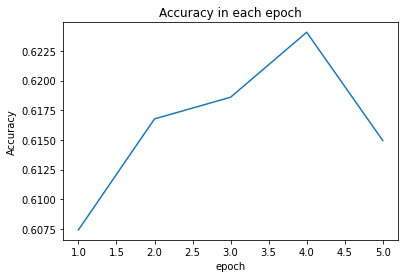

In [ ]:
df= pd.DataFrame()
df['accuracy']=accuracy_
df['epoch']=[i for i in range(1,num_epochs+1)]
plt.plot(df.epoch,df.accuracy)
plt.title("Accuracy in each epoch")
plt.xlabel("epoch")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Loss')

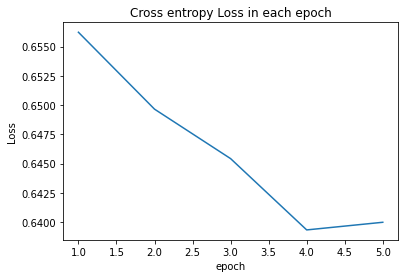

In [ ]:
df= pd.DataFrame()
df['loss']=loss_
df['epoch']=[i for i in range(1,num_epochs+1)]
plt.plot(df.epoch,df.loss)
plt.title("Cross entropy Loss in each epoch")
plt.xlabel("epoch")
plt.ylabel("Loss")

<b>Testing on Test Data

In [ ]:
correct_predction = {label: 0 for label in classes}
total_predction = {label: 0 for label in classes}
batch_size =16
with torch.no_grad():
  model.eval()
  n_correct=0.0

  for i, (images, labels) in enumerate(testDataLoader):
        images = images.to(device)
        labels = labels.to(device)
        if (i!=468):
      # Forward pass
          outputs = model(images)
          output_labels = torch.argmax(outputs,dim=1)

          n_correct += sum(labels==output_labels)

          #Checking Classwise Correct Prediction
          for j in range(batch_size):
            if labels[j] == output_labels[j]:
                  correct_predction[classes[labels[j]]]+= 1
                
            total_predction[classes[labels[j]]] += 1

print(f'Accuracy on test data: {100 * n_correct // len(testData)} %')

for label, correct_count in correct_predction.items():
    print("Accuracy for Class : ",label," is ",str(round(100 * (float(correct_count) / total_predction[label]),2)),"%",sep=" ")

Accuracy on test data: 61.0 %
Accuracy for Class :  Cat  is  88.95 %
Accuracy for Class :  Dog  is  34.06 %


In [ ]:
#https://stackoverflow.com/questions/45113245/how-to-get-mini-batches-in-pytorch-in-a-clean-and-efficient-way

<b> Mini Batch SGD with Momentum

In [ ]:
torch.cuda.empty_cache()

<b> Batch Size =4

In [ ]:
batch_size = 4
trainDataLoader = DataLoader(trainImageLoader, batch_size =batch_size, shuffle = True,pin_memory =True)
testDataLoader = DataLoader(testImageLoader, batch_size =batch_size, shuffle = True,pin_memory =True)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
print("Train Dataset Size: ", len(trainImageLoader))
print("Length of Train Data Loader",len(trainDataLoader))
print("Train Dataset Size: ", len(testImageLoader))
print("Length of Train Data Loader",len(testDataLoader))

Train Dataset Size:  4362
Length of Train Data Loader 1091
Train Dataset Size:  1873
Length of Train Data Loader 469


In [ ]:
model.train()
train_len = len(trainData)
loss_ =[]
accuracy_=[]

num_epochs = 5
for epoch in range(num_epochs):
  total_correct =0.0
  r_loss=0.0

  for i, (images, labels) in enumerate(trainDataLoader):

        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        output_label = torch.argmax(outputs,dim=1)
        total_correct+= (labels==output_label).sum().item()

        optimizer.zero_grad()
        loss = loss_function(outputs, labels)
        r_loss += loss.item()*images.size(0)
        


        # Backward and optimize
        loss.backward()
        optimizer.step()
  loss_.append(r_loss/train_len)
  accuracy_.append()
  print(f'Epoch: {epoch} Loss :{r_loss/train_len}  Accuracy :{total_correct/train_len*100}%')
print("Finished Training")

Epoch: 0 Loss :0.6684068574738676  Accuracy :61.17458866544789%
Epoch: 1 Loss :0.6490452413258213  Accuracy :62.385740402193775%
Epoch: 2 Loss :0.634709231623566  Accuracy :63.642595978062154%
Epoch: 3 Loss :0.6365009682351754  Accuracy :64.32815356489945%
Epoch: 4 Loss :0.6246256322158974  Accuracy :64.71663619744058%
Finished Training


Text(0, 0.5, 'Accuracy')

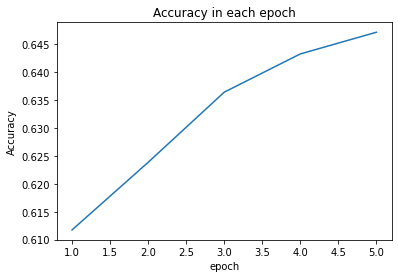

In [ ]:
df= pd.DataFrame()
df['accuracy']=accuracy_
df['epoch']=[i for i in range(1,num_epochs+1)]
plt.plot(df.epoch,df.accuracy)
plt.title("Accuracy in each epoch")
plt.xlabel("epoch")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Loss')

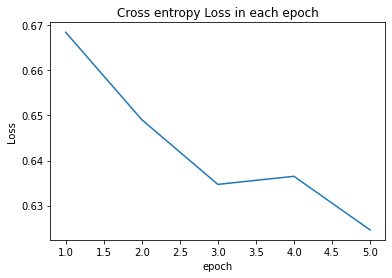

In [ ]:
df= pd.DataFrame()
df['loss']=loss_
df['epoch']=[i for i in range(1,num_epochs+1)]
plt.plot(df.epoch,df.loss)
plt.title("Cross entropy Loss in each epoch")
plt.xlabel("epoch")
plt.ylabel("Loss")

In [ ]:
correct_predction = {label: 0 for label in classes}
total_predction = {label: 0 for label in classes}
with torch.no_grad():
  model.eval()
  n_correct=0.0

  for i, (images, labels) in enumerate(testDataLoader):
        images = images.to(device)
        labels = labels.to(device)
        if (i!=468):
      # Forward pass
          outputs = model(images)
          output_labels = torch.argmax(outputs,dim=1)

          n_correct += sum(labels==output_labels)

          #Checking Classwise Correct Prediction
          for j in range(batch_size):
            if labels[j] == output_labels[j]:
                  correct_predction[classes[labels[j]]]+= 1
                
            total_predction[classes[labels[j]]] += 1

print(f'Accuracy on test data: {100 * n_correct // len(testData)} %')

for label, correct_count in correct_predction.items():
    print("Accuracy for Class : ",label," is ",str(round(100 * (float(correct_count) / total_predction[label]),2)),"%",sep=" ")

Accuracy on test data: 68.0 %
Accuracy for Class :  Cat  is  86.74 %
Accuracy for Class :  Dog  is  49.78 %


<b> Batch Size =16

In [ ]:
batch_size = 16
trainDataLoader = DataLoader(trainImageLoader, batch_size =batch_size, shuffle = True,pin_memory =True)
testDataLoader = DataLoader(testImageLoader, batch_size =batch_size, shuffle = True,pin_memory =True)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
print("Train Dataset Size: ", len(trainImageLoader))
print("Length of Train Data Loader",len(trainDataLoader))
print("Train Dataset Size: ", len(testImageLoader))
print("Length of Train Data Loader",len(testDataLoader))

Train Dataset Size:  4362
Length of Train Data Loader 273
Train Dataset Size:  1873
Length of Train Data Loader 118


In [ ]:
model.train()
train_len = len(trainData)
loss_ =[]
accuracy_=[]

num_epochs = 5
for epoch in range(num_epochs):
  total_correct =0.0
  r_loss=0.0

  for i, (images, labels) in enumerate(trainDataLoader):

        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        output_label = torch.argmax(outputs,dim=1)
        total_correct+= (labels==output_label).sum().item()

        optimizer.zero_grad()
        loss = loss_function(outputs, labels)
        r_loss += loss.item()*images.size(0)
        


        # Backward and optimize
        loss.backward()
        optimizer.step()
  loss_.append(r_loss/train_len)
  accuracy_.append(total_correct/train_len)
  print(f'Epoch: {epoch} Loss :{r_loss/train_len}  Accuracy :{total_correct/train_len*100}%')
print("Finished Training")

Epoch: 0 Loss :0.8855152101250846  Accuracy :59.43784277879342%
Epoch: 1 Loss :0.6462729209846727  Accuracy :61.585923217550274%
Epoch: 2 Loss :0.6377317527312465  Accuracy :62.36288848263254%
Epoch: 3 Loss :0.6370411593964157  Accuracy :62.45429616087751%
Epoch: 4 Loss :0.6304357312279166  Accuracy :63.391224862888485%
Finished Training


Text(0, 0.5, 'Accuracy')

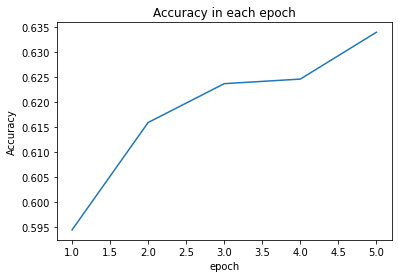

In [ ]:
df= pd.DataFrame()
df['accuracy']=accuracy_
df['epoch']=[i for i in range(1,num_epochs+1)]
plt.plot(df.epoch,df.accuracy)
plt.title("Accuracy in each epoch")
plt.xlabel("epoch")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Loss')

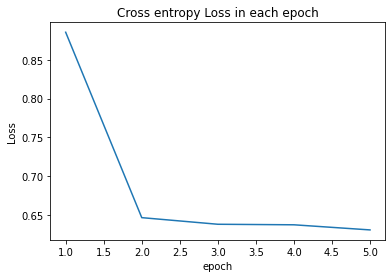

In [ ]:
df= pd.DataFrame()
df['loss']=loss_
df['epoch']=[i for i in range(1,num_epochs+1)]
plt.plot(df.epoch,df.loss)
plt.title("Cross entropy Loss in each epoch")
plt.xlabel("epoch")
plt.ylabel("Loss")

In [ ]:
correct_predction = {label: 0 for label in classes}
total_predction = {label: 0 for label in classes}
with torch.no_grad():
  model.eval()
  n_correct=0.0

  for i, (images, labels) in enumerate(testDataLoader):
        images = images.to(device)
        labels = labels.to(device)
        if (i!=117):
      # Forward pass
          outputs = model(images)
          output_labels = torch.argmax(outputs,dim=1)

          n_correct += sum(labels==output_labels)

          #Checking Classwise Correct Prediction
          for j in range(batch_size):
            if labels[j] == output_labels[j]:
                  correct_predction[classes[labels[j]]]+= 1
                
            total_predction[classes[labels[j]]] += 1

print(f'Accuracy on test data: {100 * n_correct // len(testData)} %')

for label, correct_count in correct_predction.items():
    print("Accuracy for Class : ",label," is ",str(round(100 * (float(correct_count) / total_predction[label]),2)),"%",sep=" ")

Accuracy on test data: 61.0 %
Accuracy for Class :  Cat  is  91.16 %
Accuracy for Class :  Dog  is  31.24 %


<b> Mini Batch Adam

<b> Batch Size =4

In [ ]:
batch_size = 4
trainDataLoader = DataLoader(trainImageLoader, batch_size =batch_size, shuffle = True,pin_memory =True)
testDataLoader = DataLoader(testImageLoader, batch_size =batch_size, shuffle = True,pin_memory =True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
print("Train Dataset Size: ", len(trainImageLoader))
print("Length of Train Data Loader",len(trainDataLoader))
print("Train Dataset Size: ", len(testImageLoader))
print("Length of Train Data Loader",len(testDataLoader))

Train Dataset Size:  4362
Length of Train Data Loader 1091
Train Dataset Size:  1873
Length of Train Data Loader 469


In [ ]:
torch.cuda.empty_cache()

In [ ]:
model.train()
train_len = len(trainData)
loss_ =[]
accuracy_ = []

num_epochs = 5
for epoch in range(num_epochs):
  total_correct =0.0
  r_loss=0.0

  for i, (images, labels) in enumerate(trainDataLoader):

        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        output_label = torch.argmax(outputs,dim=1)
        total_correct+= (labels==output_label).sum().item()

        optimizer.zero_grad()
        loss = loss_function(outputs, labels)
        r_loss += loss.item()*images.size(0)
        


        # Backward and optimize
        loss.backward()
        optimizer.step()
  loss_.append(r_loss/train_len)
  accuracy_.append(total_correct/train_len)
  print(f'Epoch: {epoch} Loss :{r_loss/train_len}  Accuracy :{total_correct/train_len*100}%')
print("Finished Training")

Epoch: 0 Loss :0.6483499389357112  Accuracy :59.37085465226455%
Epoch: 1 Loss :0.6381288223562988  Accuracy :61.49327269281789%
Epoch: 2 Loss :0.6326670775432489  Accuracy :62.25127913587265%
Epoch: 3 Loss :0.6253379553991306  Accuracy :63.52093992798938%
Epoch: 4 Loss :0.6187587383345986  Accuracy :64.46844798180784%
Finished Training


Text(0, 0.5, 'Accuracy')

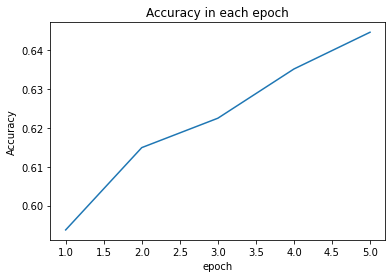

In [ ]:
df= pd.DataFrame()
df['accuracy']=accuracy_
df['epoch']=[i for i in range(1,num_epochs+1)]
plt.plot(df.epoch,df.accuracy)
plt.title("Accuracy in each epoch")
plt.xlabel("epoch")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Loss')

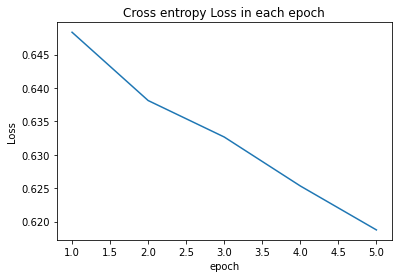

In [ ]:
df= pd.DataFrame()
df['loss']=loss_
df['epoch']=[i for i in range(1,num_epochs+1)]
plt.plot(df.epoch,df.loss)
plt.title("Cross entropy Loss in each epoch")
plt.xlabel("epoch")
plt.ylabel("Loss")

In [ ]:
correct_predction = {label: 0 for label in classes}
total_predction = {label: 0 for label in classes}
batch_size =4
with torch.no_grad():
  model.eval()
  n_correct=0.0

  for i, (images, labels) in enumerate(testDataLoader):
        images = images.to(device)
        labels = labels.to(device)
        #print(i)
        if (i!=563):
      # Forward pass
          outputs = model(images)
          output_labels = torch.argmax(outputs,dim=1)

          n_correct += sum(labels==output_labels)

          #Checking Classwise Correct Prediction
          for j in range(batch_size):
            if labels[j] == output_labels[j]:
                  correct_predction[classes[labels[j]]]+= 1
                
            total_predction[classes[labels[j]]] += 1

print(f'Accuracy on test data: {100 * n_correct // len(testData)} %')

for label, correct_count in correct_predction.items():
    print("Accuracy for Class : ",label," is ",str(round(100 * (float(correct_count) / total_predction[label]),2)),"%",sep=" ")

Accuracy on test data: 65.0 %
Accuracy for Class :  Cat  is  56.06 %
Accuracy for Class :  Dog  is  73.27 %


<b> Batch size =16

In [ ]:
batch_size = 16
trainDataLoader = DataLoader(trainImageLoader, batch_size =batch_size, shuffle = True,pin_memory =True)
testDataLoader = DataLoader(testImageLoader, batch_size =batch_size, shuffle = True,pin_memory =True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
print("Train Dataset Size: ", len(trainImageLoader))
print("Length of Train Data Loader",len(trainDataLoader))
print("Train Dataset Size: ", len(testImageLoader))
print("Length of Train Data Loader",len(testDataLoader))

Train Dataset Size:  4362
Length of Train Data Loader 273
Train Dataset Size:  1873
Length of Train Data Loader 118


In [ ]:
torch.cuda.empty_cache()

In [ ]:
model.train()
train_len = len(trainData)
loss_ =[]
accuracy_=[]

num_epochs = 5
for epoch in range(num_epochs):
  total_correct =0.0
  r_loss=0.0

  for i, (images, labels) in enumerate(trainDataLoader):

        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        output_label = torch.argmax(outputs,dim=1)
        total_correct+= (labels==output_label).sum().item()

        optimizer.zero_grad()
        loss = loss_function(outputs, labels)
        r_loss += loss.item()*images.size(0)
        


        # Backward and optimize
        loss.backward()
        optimizer.step()
  loss_.append(r_loss/train_len)
  accuracy_.append(total_correct/train_len)

  print(f'Epoch: {epoch} Loss :{r_loss/train_len}  Accuracy :{total_correct/train_len*100}%')
print("Finished Training")

Epoch: 0 Loss :0.6661846342154352  Accuracy :60.10054844606947%
Epoch: 1 Loss :0.6376538970516195  Accuracy :62.088665447897625%
Epoch: 2 Loss :0.6319416199131466  Accuracy :62.95703839122486%
Epoch: 3 Loss :0.6322567548732217  Accuracy :62.8199268738574%
Epoch: 4 Loss :0.6201707428998877  Accuracy :64.37385740402193%
Finished Training


Text(0, 0.5, 'Accuracy')

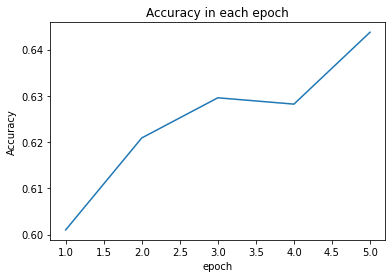

In [ ]:
df= pd.DataFrame()
df['accuracy']=accuracy_
df['epoch']=[i for i in range(1,num_epochs+1)]
plt.plot(df.epoch,df.accuracy)
plt.title("Accuracy in each epoch")
plt.xlabel("epoch")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Loss')

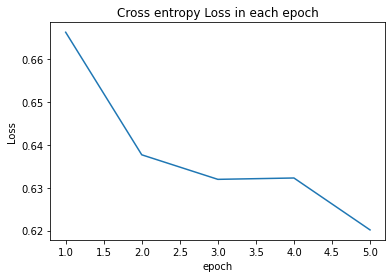

In [ ]:
df= pd.DataFrame()
df['loss']=loss_
df['epoch']=[i for i in range(1,num_epochs+1)]
plt.plot(df.epoch,df.loss)
plt.title("Cross entropy Loss in each epoch")
plt.xlabel("epoch")
plt.ylabel("Loss")

In [ ]:
correct_predction = {label: 0 for label in classes}
total_predction = {label: 0 for label in classes}
batch_size =4
with torch.no_grad():
  model.eval()
  n_correct=0.0

  for i, (images, labels) in enumerate(testDataLoader):
        images = images.to(device)
        labels = labels.to(device)
        #print(i)
        if (i!=117):
      # Forward pass
          outputs = model(images)
          output_labels = torch.argmax(outputs,dim=1)

          n_correct += sum(labels==output_labels)

          #Checking Classwise Correct Prediction
          for j in range(batch_size):
            if labels[j] == output_labels[j]:
                  correct_predction[classes[labels[j]]]+= 1
                
            total_predction[classes[labels[j]]] += 1

print(f'Accuracy on test data: {100 * n_correct // len(testData)} %')

for label, correct_count in correct_predction.items():
    print("Accuracy for Class : ",label," is ",str(round(100 * (float(correct_count) / total_predction[label]),2)),"%",sep=" ")

Accuracy on test data: 65.0 %
Accuracy for Class :  Cat  is  90.2 %
Accuracy for Class :  Dog  is  41.7 %
